
1-the vertices are zero based                                                                                                                                                  
 2-adj[] >> the adjacency list representation of the graph                                      
 3-add_edge >>  a function to add new edge to the Graph                                                                                       
 4-is_safe >> checks if it is safe to assign color 'c' to 'node'                                                                                             
 5-rec >> recursive function to find the minimum number of colors.                              
 6-solve >> main function to setup and start the recursive search.                              
 7-visualize_solution >> visualizes the colored graph using NetworkX and Matplotlib.            
 8-to initialize  the graph   GraphColoringBacktracking(number_of_vertices)
 to add edges use add_edge(u,v) function where u and v are vertices between which edge

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
from typing import List, Dict, Tuple, Set
from dataclasses import dataclass
from copy import deepcopy

In [25]:
class Graph:
    """
    Model: Responsible ONLY for the graph data structure.
    """

    def __init__(self, vertices):
        self.V = vertices
        self.adj = [[] for _ in range(vertices)] #store a list of all the vertices directly connected to vertex i

    def add_edge(self, u, v):
        self.adj[u].append(v)
        self.adj[v].append(u)  #undirected graph


In [26]:
class GraphVisualizer:
    """View: Visualizes a colored graph using NetworkX"""
    def __init__(self, graph):
        self.graph_data = graph
        self.palette = [
            'magenta', 'teal', 'red', 'green', 'blue',
            'yellow', 'orange', 'purple', 'cyan', 'pink',
            'gray', 'brown', 'lime', 'indigo', 'gold'
        ]

    def draw_solution(self, color_assignments, chromatic_number, elapsed_time=None):
        G_visual = nx.Graph()
        G_visual.add_nodes_from(range(self.graph_data.V))
        for u in range(self.graph_data.V):
            for v in self.graph_data.adj[u]:
                if u < v:  # prevents duplication
                    G_visual.add_edge(u, v)

        color_map = []
        for i in color_assignments:
            color_idx = (i - 1) % len(self.palette)
            color_map.append(self.palette[color_idx])

        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G_visual, seed=42)
        nx.draw_networkx_nodes(G_visual, pos, node_color=color_map, node_size=700, edgecolors='black')
        nx.draw_networkx_labels(G_visual, pos, font_color='white', font_weight='bold')
        nx.draw_networkx_edges(G_visual, pos, width=2)

        title = f"Graph Coloring Solution\nChromatic Number: {chromatic_number}"
        if elapsed_time is not None:
            title += f"\nTime Taken: {elapsed_time:.6f} sec"
        plt.title(title)

        plt.axis('off')
        plt.show()


#2-Cultural Algorithm Components

In [27]:
class Individual:
    """Represents a single coloring solution"""
    def __init__(self, graph, coloring=None, max_colors=None):
        self.graph = graph
        self.max_colors = max_colors or graph.V
        if coloring is None:
            # random colors from 1 to max_colors
            self.coloring = [random.randint(1, self.max_colors) for _ in range(graph.V)]
        else:
            self.coloring = coloring
        self.fitness = 0
        self.conflicts = 0
        self.chromatic_number = 0
        self.evaluate()

    def evaluate(self):
        """Calculate fitness based on conflicts and number of colors used"""
        self.conflicts = 0
        for u in range(self.graph.V):
            for v in self.graph.adj[u]:
                if u < v and self.coloring[u] == self.coloring[v]:  # ensure each edge is checked only once
                    self.conflicts += 1 #conflict found

        self.chromatic_number = len(set(self.coloring))

        if self.conflicts == 0:
            self.fitness = 10000 - self.chromatic_number  # reward fewer colors
        else:
            self.fitness = -self.conflicts * 100 - self.chromatic_number  # penalize conflicts

    def is_valid(self):
        return self.conflicts == 0

In [28]:
class BeliefSpace:
    """
    Enhanced Belief Space with three types of knowledge:
    1. Situational Knowledge: Best overall solution found
    2. Normative Knowledge: Successful color patterns per vertex- Good color choices per vertex --> influence function,Mutation
    3. Domain Knowledge: Color usage frequency and constraints- Global constraints and patterns
    """

    def __init__(self, graph, size=5):
        self.graph = graph
        self.size = size

        # 1.Situational Knowledge
        self.best_solution = None

        # 2.Normative Knowledge
        self.normative = [None] * graph.V  # Most successful color for each V[i]
        self.color_frequency = [{} for _ in range(graph.V)]

        # 3.Domain Knowledge
        self.min_colors_found = float('inf')
        self.successful_patterns = []  # Store top solutions

    def update(self, population):
        """Update all three knowledge types from population"""
        valid_individuals = [ind for ind in population if ind.is_valid()]

        if not valid_individuals:
            return

        # Update Situational Knowledge (best solution)
        current_best = min(valid_individuals, key=lambda x: x.chromatic_number) #best= min chromatic no.
        if self.best_solution is None or current_best.chromatic_number < self.best_solution.chromatic_number:
            self.best_solution = deepcopy(current_best) #copy and won't be modified,ind. evolves
            self.min_colors_found = current_best.chromatic_number

        # Update Normative Knowledge (color patterns)
        self._update_normative(valid_individuals)

        # Update Domain Knowledge (successful patterns)
        self._update_domain(valid_individuals)

    def _update_normative(self, valid_individuals):
        """Track which colors work best for each vertex"""
        # Count color usage for each vertex across successful solutions
        for ind in valid_individuals[:self.size]:
            for vertex, color in enumerate(ind.coloring):
                if color not in self.color_frequency[vertex]:
                    self.color_frequency[vertex][color] = 0     #add color to my knowledge with initialization=0
                self.color_frequency[vertex][color] += 1

        # Determine most successful color for each vertex
        for vertex in range(self.graph.V):
            if self.color_frequency[vertex]:
                self.normative[vertex] = max(   #highest frequency value-> high fitness
                    self.color_frequency[vertex].items(),
                    key=lambda x: x[1]
                )[0]

    def _update_domain(self, valid_individuals):
        """Store patterns from successful solutions"""
        # Keep top solutions as patterns
        sorted_valid = sorted(valid_individuals, key=lambda x: x.chromatic_number)
        self.successful_patterns = [deepcopy(ind) for ind in sorted_valid[:self.size]]

    def influence(self, individual, rate=0.3):
        """
        Apply belief space knowledge to guide an individual
        Uses all three knowledge types probabilistically ,
        guides the evolution of a new individual based on the stored knowledge.
        """
        if random.random() > rate: #influnce chance = rate or less
            return

        influence_type = random.choice(['situational', 'normative', 'domain'])


        if influence_type == 'situational' and self.best_solution:
            # Apply best solution knowledge

            num_genes = random.randint(1, max(1, len(individual.coloring) // 3)) #Randomly choose 1 to N/3 positions
            #if graph has 9 vertices → choose between 1 and 3 positions to copy.

            positions = random.sample(range(len(individual.coloring)), num_genes)
            for pos in positions:
                individual.coloring[pos] = self.best_solution.coloring[pos]
            #The individual becomes more similar to the best solution — but not identical.


        elif influence_type == 'normative' and any(self.normative):
            # store successful color patterns
            for vertex in range(len(individual.coloring)):
                if self.normative[vertex] is not None and random.random() < 0.3:
                    # Check if this color is safe
                    neighbor_colors = {individual.coloring[n] for n in self.graph.adj[vertex]}
                    if self.normative[vertex] not in neighbor_colors:
                        individual.coloring[vertex] = self.normative[vertex]


        elif influence_type == 'domain' and self.successful_patterns:
            # Apply domain knowledge (patterns from successful solutions)

            pattern = random.choice(self.successful_patterns) #randomly selects one solution
            num_genes = random.randint(1, max(1, len(individual.coloring) // 4))
            positions = random.sample(range(len(individual.coloring)), num_genes)
            for pos in positions:
                individual.coloring[pos] = pattern.coloring[pos]
                #spread of good sub-patterns found in top solutions.

        individual.evaluate()

In [29]:
def plot_ca_performance(history):
    """
    Visualizes the improvement of the coloring solution over generations.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(history)), history, color='blue', linewidth=2, label='Best Chromatic Number')

    plt.title("Cultural Algorithm Performance Across Generations", fontsize=14)
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Chromatic Number / Penalty Score", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [30]:
class CulturalAlgorithm:
    """Cultural Algorithm for graph coloring with enhanced belief space"""

    def __init__(self, graph, population_size=50, mutation_rate=0.1,
                 influence_rate=0.3, belief_space_size=5, max_colors=None):
        self.graph = graph
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.influence_rate = influence_rate
        self.max_colors = max_colors or graph.V
        self.population = [Individual(graph, max_colors=self.max_colors)
                          for _ in range(population_size)]
        self.belief_space = BeliefSpace(graph, size=belief_space_size)
        self.best_solution = None

    def select_parent(self):
        """Tournament selection"""
        tournament = random.sample(self.population, min(5, len(self.population)))
         #ensure that if the population size is less than 5, it simply selects all individuals in the population.
        return max(tournament, key=lambda x: x.fitness)

    def crossover(self, parent1, parent2):
        """Single-point crossover"""
        point = random.randint(1, self.graph.V - 1)
        child_coloring = parent1.coloring[:point] + parent2.coloring[point:]
        return Individual(self.graph, child_coloring, max_colors=self.max_colors)

    def mutate(self, individual):
        """Mutate by changing random colors intelligently"""
        for i in range(len(individual.coloring)):
            if random.random() < self.mutation_rate:
                neighbor_colors = {individual.coloring[neighbor]
                                 for neighbor in self.graph.adj[i]}
                available = [c for c in range(1, self.max_colors + 1) #safe colors option
                           if c not in neighbor_colors]
                if available:
                    individual.coloring[i] = random.choice(available)
                else:   #No Safe Color Exists
                    individual.coloring[i] = random.randint(1, self.max_colors)

        individual.evaluate()

    def evolve(self):
        """Create next generation with belief space influence"""
        self.population.sort(key=lambda x: x.fitness, reverse=True)

        # Update belief space with current population
        self.belief_space.update(self.population)

        # Elitism: keep best 2
        new_population = self.population[:2]

        # Generate offspring
        while len(new_population) < self.population_size:
            parent1 = self.select_parent()
            parent2 = self.select_parent()

            child = self.crossover(parent1, parent2)
            self.mutate(child)

            # Apply belief space influence
            self.belief_space.influence(child, rate=self.influence_rate)

            new_population.append(child)

        self.population = new_population

    def solve(self, max_generations=100, verbose=True):
        """Run the cultural algorithm"""
        if verbose:
            print(f"\nStarting Cultural Algorithm...")
            print(f"Population size: {self.population_size}")

        start_time = time.time()

        for gen in range(max_generations):
            self.evolve()

            current_best = max(self.population, key=lambda x: x.fitness)
            if self.best_solution is None or current_best.fitness > self.best_solution.fitness:
                self.best_solution = deepcopy(current_best)

            if verbose and (gen % 20 == 0 or gen == max_generations - 1):
                valid_count = sum(1 for ind in self.population if ind.is_valid())
                print(f"Gen {gen}: Best={self.best_solution.chromatic_number if self.best_solution.is_valid() else 'invalid'}, "
                      f"Valid={valid_count}/{self.population_size}, Conflicts={self.best_solution.conflicts}")

        elapsed = time.time() - start_time

        if verbose:
            if self.best_solution.is_valid():
                print(f"\n✓ Valid Solution Found!")
                print(f"Chromatic Number: {self.best_solution.chromatic_number}")
                print(f"Color assignments: {self.best_solution.coloring}")
            else:
                print(f"\n✗ No valid solution found")
                print(f"Best solution has {self.best_solution.conflicts} conflicts")
            print(f"Computational time: {elapsed:.2f} seconds")

        return self.best_solution.coloring, self.best_solution.chromatic_number


# Testing set

In [31]:
def load_graph(filename):
    """Load graph from DIMACS format file"""
    graph = None
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('c'):  # comment
                continue
            elif line.startswith('p'):  # problem line
                parts = line.split()
                vertices = int(parts[2])
                graph = Graph(vertices)
            elif line.startswith('e'):  # edge
                parts = line.split()
                u = int(parts[1]) - 1  # convert to 0-based
                v = int(parts[2]) - 1
                graph.add_edge(u, v)
    return graph
#my_graph = load_graph('graph testing set.txt')


# 3-MAIN

                    GRAPH COLORING PROBLEM SOLVER                     
            Cultural Algorithm with Enhanced Belief Space             

Input Mode:
1. Manual Input
2. Load Graph from File (. txt / DIMACS)

Choice (1/2): 2

Enter file name: graph testing set.txt
✓ Loaded graph with 250 vertices

                    CULTURAL ALGORITHM PARAMETERS                     
Population size (default 50): 
Max generations (default 100): 
Mutation rate (default 0.1): 
Belief influence rate (default 0.3): 
Belief space size (default 5): 

Starting Cultural Algorithm...
Population size: 50
Gen 0: Best=invalid, Valid=0/50, Conflicts=29
Gen 20: Best=167, Valid=14/50, Conflicts=0
Gen 40: Best=158, Valid=16/50, Conflicts=0
Gen 60: Best=158, Valid=25/50, Conflicts=0
Gen 80: Best=154, Valid=23/50, Conflicts=0
Gen 99: Best=154, Valid=25/50, Conflicts=0

✓ Valid Solution Found!
Chromatic Number: 154
Color assignments: [196, 171, 38, 130, 101, 213, 172, 10, 210, 24, 214, 178, 175, 25, 45, 145, 156, 66,

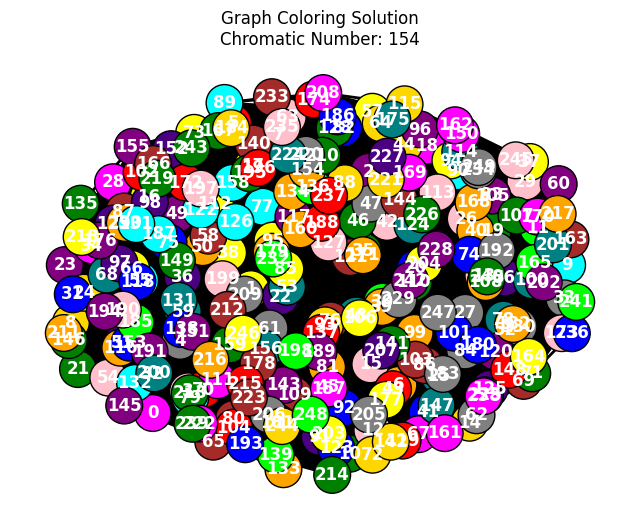

In [33]:
if __name__ == "__main__":
    print("="*70)
    print("GRAPH COLORING PROBLEM SOLVER". center(70))
    print("Cultural Algorithm with Enhanced Belief Space".center(70))
    print("="*70)

    # -------------------------
    # INPUT MODE
    # -------------------------
    print("\nInput Mode:")
    print("1. Manual Input")
    print("2. Load Graph from File (. txt / DIMACS)")

    input_choice = input("\nChoice (1/2): ").strip()

    # -------------------------
    # OPTION 1: MANUAL INPUT
    # -------------------------
    if input_choice == '1':
        n = int(input("\nEnter number of vertices: "))
        my_graph = Graph(n)

        edges_count = int(input("Enter number of edges: "))
        print("Enter edges as:  u v  (1-based vertices)")

        for i in range(edges_count):
            u, v = map(int, input(f"Edge {i+1}:  ").split())
            my_graph.add_edge(u - 1, v - 1)

    # -------------------------
    # OPTION 2: LOAD FROM FILE
    # -------------------------
    elif input_choice == '2':
        filename = input("\nEnter file name: ").strip()
        my_graph = load_graph(filename)
        print(f"✓ Loaded graph with {my_graph.V} vertices")

    else:
        print("Invalid choice. Exiting...")
        exit()

    # -------------------------
    # CULTURAL ALGORITHM PARAMETERS
    # -------------------------
    print("\n" + "="*70)
    print("CULTURAL ALGORITHM PARAMETERS".center(70))
    print("="*70)

    pop_size = int(input("Population size (default 50): ") or "50")
    max_gen = int(input("Max generations (default 100): ") or "100")
    mut_rate = float(input("Mutation rate (default 0.1): ") or "0.1")
    inf_rate = float(input("Belief influence rate (default 0.3): ") or "0.3")
    belief_size = int(input("Belief space size (default 5): ") or "5")

    # -------------------------
    # RUN CULTURAL ALGORITHM
    # -------------------------
    ca = CulturalAlgorithm(
        my_graph,
        population_size=pop_size,
        mutation_rate=mut_rate,
        influence_rate=inf_rate,
        belief_space_size=belief_size
    )

    solution, chromatic_num = ca.solve(max_generations=max_gen)

    # -------------------------
    # VISUALIZE SOLUTION
    # -------------------------
    visualizer = GraphVisualizer(my_graph)
    visualizer.draw_solution(solution, chromatic_num, elapsed_time=None)